# Crossvalidation with the GridSearchCV and Pipeline objects

To help with common use cases for cross-validation, sklearn provides a few convenience objects, most notably the `GridSearchCV` object (to perform cross-validation on a grid of hyperparameters) and the `Pipeline` object (to train a sequence of estimators at the same time).

In this demo, we illustrate the usage of these object on the "diabetes" dataset, which is shipped with sklearn.

The dataset contains 10 input variables (age, sex, body mass index, average blood pressure, and six blood serum measurements), and one target variable (a measure of disease progression one year after the measurement of the input variables).

In [1]:
# A few useful imports and settings.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.cross_validation import train_test_split
from sklearn import datasets, linear_model, preprocessing

# Make notebook reproducible.
random_state = np.random.RandomState(7374)

In [2]:
# Load the diabetes dataset, and split it in a training and a test set.
diabetes = datasets.load_diabetes()

x = diabetes.data
t = diabetes.target
x_train, x_test, t_train, t_test = train_test_split(
    x, t, test_size=0.25, random_state=random_state)

print 'Size of training set:', len(x_train)
print 'Size of test set:', len(x_test)

Size of training set: 331
Size of test set: 111


We are going to use a linear regression model, which is sensitive to the scale of the input variables. As a preprocessing step, we normalize all inputs to have zero mean and unit variance.

In [3]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_test = scaler.transform(x_test)
x_train = scaler.transform(x_train)

For comparison, let's have a look at what we should do in order to manually perform cross-validation to select the `gamma` and `C` parameters for a Support Vector Regressor.

In [4]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR

gammas = np.logspace(-3, -1, 10)
Cs = [1, 10, 100]

scores = []
for gamma in gammas:
    for C in Cs:
        regr = SVR(gamma=gamma, C=C)
        all_scores = cross_val_score(regr, x_train, t_train, cv=4)
        scores.append((gamma, C, np.mean(all_scores)))

scores

[(0.001, 100, 0.41779396946607339),
 (0.0016681005372000592, 100, 0.45561340476808732),
 (0.0027825594022071257, 100, 0.47148989516490569),
 (0.0046415888336127772, 100, 0.48082482143669114),
 (0.0077426368268112694, 100, 0.49647996595550853),
 (0.01291549665014884, 100, 0.49941020161219418),
 (0.021544346900318832, 100, 0.49863199418839665),
 (0.035938136638046257, 100, 0.48892513293946616),
 (0.059948425031894091, 100, 0.4766673067702154),
 (0.10000000000000001, 100, 0.43382441934463994)]

... and we would still need to search for the parameters corresponding to the maximum average score.

The `GridSearchCV` object eliminates the need to manually manage iterating over all parameters, and finding the optimal parameters setting. In the example below, we perform cross validation not only on the grid of parameters defined above, but also on the kernel type (`'linear'` vs `'rbf'`).

In [5]:
from sklearn.grid_search import GridSearchCV

# This is a list of dictionary. Each dictionary defines a new full
# grid, with a set of values for each of the parameters of an estimator.
param_grid = [
    {'kernel': ['linear'], 'C': Cs},
    {'kernel': ['rbf'], 'gamma': gammas, 'C': Cs},
]

grid_search = GridSearchCV(SVR(), param_grid, cv=4)
grid_search.fit(x_train, t_train);

In [6]:
# We can request the scores for each point on the grid.
grid_search.grid_scores_

[mean: 0.47888, std: 0.09502, params: {'kernel': 'linear', 'C': 1},
 mean: 0.47403, std: 0.08574, params: {'kernel': 'linear', 'C': 10},
 mean: 0.46751, std: 0.08293, params: {'kernel': 'linear', 'C': 100},
 mean: -0.02227, std: 0.03689, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.001},
 mean: -0.01334, std: 0.03797, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.0016681005372000592},
 mean: 0.00041, std: 0.03770, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.0027825594022071257},
 mean: 0.01921, std: 0.03797, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.0046415888336127772},
 mean: 0.04654, std: 0.04075, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.0077426368268112694},
 mean: 0.07989, std: 0.04372, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.01291549665014884},
 mean: 0.11262, std: 0.04673, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.021544346900318832},
 mean: 0.13627, std: 0.04809, params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.035938136638046257},
 mean: 0.14106, std: 0.04436, param

In [7]:
# The GridCV object also keeps track of the best estimator
best_regr = grid_search.best_estimator_
print 'Best regressor:', best_regr
print 'Best score on held-out data:', grid_search.best_score_

Best regressor: SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.01291549665014884, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
Best score on held-out data: 0.499148242982


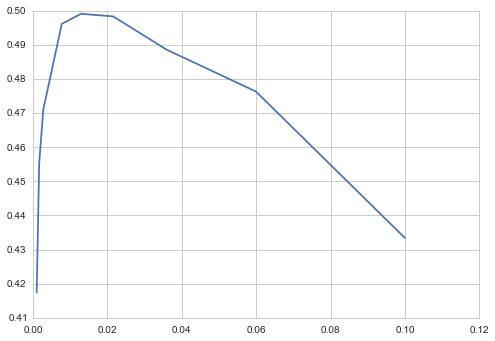

In [8]:
# Let's see how the r2 score depends on the parameter 'gamma'.
best_C = best_regr.C
gamma_scores = [score.mean_validation_score for score in grid_search.grid_scores_
                if score.parameters['C']==100 and score.parameters['kernel']=='rbf']
plt.plot(gammas, gamma_scores)

In [9]:
# At the end of the cross-validation process, the best estimator is re-fit
# with all the training data, and we can use the GridSearchCV object as
# an estimator.
y_test = grid_search.predict(x_test)
print 'Test score = ', grid_search.score(x_test, t_test)

Test score =  0.494984760594


The steps presented so far can be improved further. One (minor) problem with our example so far, is that the scaler object has been trained on the whole training data, while the cross-validation training is performed on subset of the training data. Ideally, the scaler should not see the held-out data, but rather trained with on the subset, as well.

We can easily take this into account by create a `Pipeline`.

In [10]:
from sklearn.pipeline import Pipeline

# Each tuple in the pipeline is ('name for estimator', estimator)
workflow = Pipeline([('scaler', preprocessing.StandardScaler()), ('regressor', SVR())])

# Note the naming convention used to refer to the parameters of a specific estimator in the pipeline.
param_grid = [{'regressor__kernel': ['rbf'], 'regressor__gamma': gammas, 'regressor__C': Cs}]

grid_search = GridSearchCV(workflow, param_grid, cv=4)
grid_search.fit(x_train, t_train)

GridSearchCV(cv=4,
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regressor', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'regressor__kernel': ['rbf'], 'regressor__gamma': array([ 0.001  ,  0.00167,  0.00278,  0.00464,  0.00774,  0.01292,
        0.02154,  0.03594,  0.05995,  0.1    ]), 'regressor__C': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [11]:
# At the end of the cross-validation process, compute the final score
# on the test set.
y_test = grid_search.predict(x_test)
print 'Test score = ', grid_search.score(x_test, t_test)

Test score =  0.494984760594
